# House Prices Estimator

__Note:__ It's a competition from __Kaggle.com__ and the input data was retrieved from there.


## Data Analysis

In [107]:
import numpy as np
import pandas as pd

#load the files
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')
data = pd.concat([train, test])

#size of training dataset
train_samples = train.shape[0]
test_samples = test.shape[0]

In [108]:
# remove the Id feature
data.drop(['Id'],1, inplace=True);

In [109]:
#data.describe()

In [110]:
datanum = data.select_dtypes([np.number])
datanum = datanum.fillna(datanum.dropna().mean())

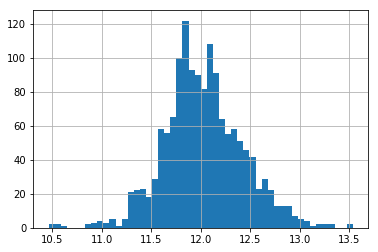

In [111]:
import matplotlib.pyplot as plt
%matplotlib inline
# Transforming to non-skewed SalePrice
data.SalePrice = data.SalePrice.apply(np.log)
data.SalePrice.hist(bins=50)

In [112]:
# Correlation features
datanum.corr()['SalePrice'].sort_values(ascending=False).head(5)

SalePrice      1.000000
OverallQual    0.547865
GrLivArea      0.518693
GarageCars     0.444010
GarageArea     0.437270
Name: SalePrice, dtype: float64

In [113]:
high_corr_feat_names = datanum.corr()['SalePrice'].sort_values(ascending=False).head(10).axes[0].tolist()
high_corr_feat_names.remove('SalePrice')
datanum_high_corr = datanum[high_corr_feat_names]

#### KFold

In [114]:
from sklearn.model_selection import KFold

y = np.array(data['SalePrice'])
X = np.array(datanum_high_corr)

#split by idx
idx = train_samples
X_train, X_test = X[:idx], X[idx:]
y_train, y_test = y[:idx], y[idx:]

print("Shape X train: {}".format(X_train.shape))
print("Shape y train: {}".format(y_train.shape))
print("Shape X test: {}".format(X_test.shape))
print("Shape y test: {}".format(y_test.shape))

kf = KFold(n_splits=10, random_state=13)#, shuffle=True)
print(kf)

Shape X train: (1460, 9)
Shape y train: (1460,)
Shape X test: (1459, 9)
Shape y test: (1459,)
KFold(n_splits=10, random_state=13, shuffle=False)


In [115]:
#plotting PCA
from sklearn.decomposition import PCA

def getX_PCA(X):
    pca = PCA(n_components=1)
    return pca.fit(X).transform(X)
    
def plotPCA(X, y):
    pca = PCA(n_components=1)
    X_r = pca.fit(X).transform(X)
    plt.plot(X_r, y, 'x')

/Users/samuel/anaconda/envs/py3/lib/python3.5/site-packages/sklearn/covariance/robust_covariance.py:161: RuntimeWarning: Warning! det > previous_det (39.999239109922257 > -inf)
  % (det, previous_det), RuntimeWarning)


Number samples: 1445


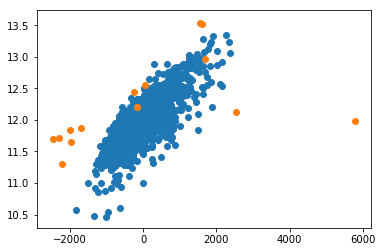

In [116]:
from sklearn.covariance import EllipticEnvelope

# fit the model
ee = EllipticEnvelope(contamination=0.01,
                      assume_centered=True,
                      random_state=13)
ee.fit(X_train)
pred = ee.predict(X_train)

X_train_orig = X_train
y_train_orig = y_train

X_bad = X_train[pred != 1]
y_bad = y_train[pred != 1]
X_train = X_train[pred == 1]
y_train = y_train[pred == 1]
print("Number samples: {}".format(X_train.shape[0]))

#after removing anomalies
plt.scatter(getX_PCA(X_train), y_train)
plt.scatter(getX_PCA(X_bad), y_bad)

### Models

In [117]:
# Linear regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def train(X_train, y_train, verbose=True):
    lr = LinearRegression()

    #
    batch = 0
    for train_idx, val_idx in kf.split(X_train, y_train):
        X_t, X_v = X_train[train_idx], X_train[val_idx]
        y_t, y_v = y_train[train_idx], y_train[val_idx]

        #training
        lr.fit(X_t, y_t)

        #calculate costs
        t_error = mean_squared_error(y_t, lr.predict(X_t))**0.5
        v_error = mean_squared_error(y_v, lr.predict(X_v))**0.5
        if verbose:
            print("{}) Training error: {:.2f}  Validation error: {:.2f} Score: {:.2f}"
                  .format(batch, t_error, v_error, lr.score(X_v, y_v)))
        batch += 1
        
    return lr

def metrics(model, X, y, verbose=True):
    #Scores
    if verbose:
        print("Training score: {:.4f}".format(model.score(X, y)))
    #RMSLE
    rmsle = mean_squared_error(y, model.predict(X))**0.5
    if verbose:
        print("RMSLE: {:.4f}".format(rmsle))
        # Plotting the results
        plt.scatter(model.predict(X), y)
        
    return rmsle

0) Training error: 0.15  Validation error: 0.16 Score: 0.83
1) Training error: 0.16  Validation error: 0.15 Score: 0.86
2) Training error: 0.15  Validation error: 0.16 Score: 0.86
3) Training error: 0.15  Validation error: 0.16 Score: 0.86
4) Training error: 0.15  Validation error: 0.17 Score: 0.84
5) Training error: 0.15  Validation error: 0.15 Score: 0.83
6) Training error: 0.15  Validation error: 0.15 Score: 0.84
7) Training error: 0.15  Validation error: 0.15 Score: 0.84
8) Training error: 0.15  Validation error: 0.15 Score: 0.83
9) Training error: 0.15  Validation error: 0.16 Score: 0.85
Training score: 0.8011
RMSLE: 0.1781


0.17808229207754026

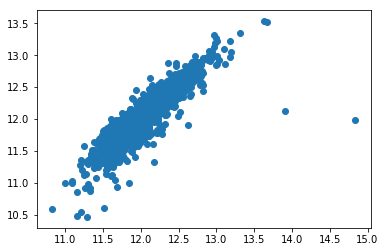

In [118]:
model = train(X_train, y_train)
metrics(model, X_train_orig, y_train_orig)

In [119]:
# Get polynomial features
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)

X_train_orig_pol = poly.fit_transform(X_train_orig)
X_train_pol = poly.fit_transform(X_train)
X_test_pol = poly.fit_transform(X_test)

0) Training error: 0.15  Validation error: 0.15 Score: 0.83
1) Training error: 0.15  Validation error: 0.14 Score: 0.87
2) Training error: 0.15  Validation error: 0.16 Score: 0.86
3) Training error: 0.15  Validation error: 0.16 Score: 0.85
4) Training error: 0.15  Validation error: 0.17 Score: 0.85
5) Training error: 0.15  Validation error: 0.16 Score: 0.81
6) Training error: 0.15  Validation error: 0.15 Score: 0.84
7) Training error: 0.15  Validation error: 0.15 Score: 0.83
8) Training error: 0.15  Validation error: 0.15 Score: 0.84
9) Training error: 0.15  Validation error: 0.15 Score: 0.85
Training score: 0.8514
RMSLE: 0.1539


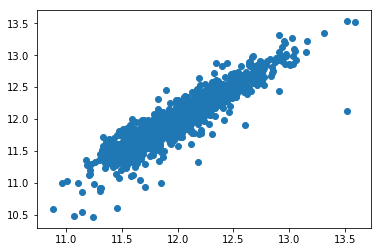

In [120]:
model = train(X_train_pol, y_train)
metrics(model, X_train_orig_pol, y_train_orig)

rmsles = []
for f in range(1,55):
    model = train(X_train_pol[:,:f], y_train, verbose=False)
    rmsles.append(metrics(model, X_train_orig_pol[:,:f], y_train_orig, verbose=False))

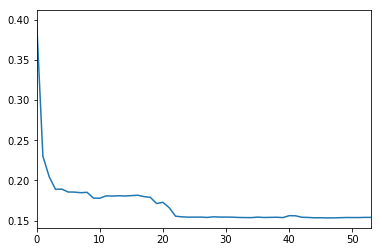

In [121]:
pd.Series(rmsles).plot()

In [122]:
model = train(X_train_pol[:,:22], y_train, verbose=False)
metrics(model, X_train_orig_pol[:,:22], y_train_orig, verbose=False)

0.16611742840563029

## Get Predictions

In [73]:
import os

predict = model.predict(poly.fit_transform(X_test)[:,:22])

#predictions are logs, return to the value
predict = np.exp(predict)

file = "Id,SalePrice" + os.linesep

startId = 1461
for i in range(len(X_test)):
    file += "{},{}".format(startId, (int)(predict[i])) + os.linesep
    startId += 1

#print(file)

In [74]:
# Save to file
with open('attempt.txt', 'w') as f:
    f.write(file)